# Capstone Project: Predicting the need for hospital admittance using machine learning

By: Yash Nagpaul

*(Data Science Diploma Candidate, BrainStation)*

## Table of Contents:
1. <a href="#">Introduction</a>
2. <a href="part-1">Part 1 - Data Cleaning</a>
---
### Introduction
The aim of this report is to predict whether or not a person needs to be admitted to the hospital. We have a dataset of over 560,000 unidentified patients. The dataset consists of 972 unqiue features.

In [39]:
# import helper libraries

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data/admit_data.csv')
df

In [3]:
# work with a 10% sample
df = df.groupby('disposition').sample(frac=0.1, random_state=1011)
df

In [4]:
# drop duplicate index column
df = df.drop(columns=['Unnamed: 0'])
df

In [5]:
# reset index values since we're working with a random 10% sample
df.reset_index(drop=True, inplace=True)
df

In [6]:
# Check for duplicate rows
df.duplicated().sum()

0

In [7]:
# Only 2 rows are duplicates, we can drop the duplicates with confidence because:
# it's an extremely small proprtion of the data, and
# we have over 900 features, which makes it very likely that the duplicate row is not intentional
df.drop_duplicates(inplace=True)

In [32]:
# TODO: deal with nulls

# get a sense of how many null values we have in our dataset
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(df[column].isna().sum())

239
1
34529
56013
43480
44876
43358
34295
35115
43743
55021
51990
54535
34299
51340
56049
50515
43460
34967
39653
34852
51587
52204
51996
34963
54778
34971
54538
51002
34969
55087
55279
52026
53212
34300
51483
56047
45037
34993
51905
54535
34026
34036
51687
51685
48227
50468
49422
34283
51091
33892
33892
33883
34155
51544
33949
34140
51338
51463
54539
51990
54535
54534
56049
52131
33897
51991
54535
50434
50433
47858
50424
50426
51641
50437
50424
55966
35336
45142
48233
51016
33885
51647
33884
34963
49378
54719
54219
33883
51512
31701
55835
37641
38738
37527
31553
31932
37822
53407
47035
53573
31565
50871
56047
44320
37621
31833
35257
31779
46180
47656
47044
31828
52051
31829
53573
45639
31833
53406
54352
50186
51853
31566
51033
56044
38885
31849
48224
53573
31411
31418
51172
51170
42392
45434
43959
31555
45233
31320
31320
31313
31466
51010
31333
31456
50676
51017
53574
47035
53573
53573
56049
46694
31317
47040
53571
44395
44394
42045
44380
44384
46159
44392
44378
55619
32027
38987
4239

#### OBSERVATIONS:
- The dataset has a high level of sparsity (many missing values)

In [9]:
# How many non-numeric columns do we have?

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(exclude=numerics).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56049 entries, 0 to 56048
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dep_name          56049 non-null  object
 1   gender            56049 non-null  object
 2   ethnicity         56049 non-null  object
 3   race              56046 non-null  object
 4   lang              56049 non-null  object
 5   religion          56049 non-null  object
 6   maritalstatus     56049 non-null  object
 7   employstatus      56049 non-null  object
 8   insurance_status  56049 non-null  object
 9   disposition       56049 non-null  object
 10  arrivalmode       53870 non-null  object
 11  arrivalmonth      56049 non-null  object
 12  arrivalday        56049 non-null  object
 13  arrivalhour_bin   56049 non-null  object
 14  previousdispo     56049 non-null  object
dtypes: object(15)
memory usage: 6.8+ MB


#### NOTES:
- A total of 15 non-numeric columns that either need to be converted to numeric somehow or dropped

### `disposition` column
- Convert the column values to binary
- `Admit` = 1
- `Discharge` = 0

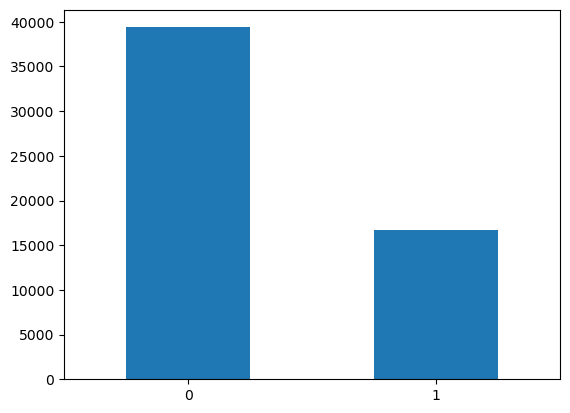

In [41]:
# first, visualize the distribution of classes in our target column

plt.figure()
df['disposition'].value_counts().plot(kind='bar', rot=0)
plt.show()

In [42]:
df['disposition'].value_counts(normalize=True)

0    0.702689
1    0.297311
Name: disposition, dtype: float64

**Note**: Before splitting the dataset for model training, we will need to account for this imbalance between the classes in our target variable.

In [10]:
# Convert to binary

df.disposition = df.disposition.apply(lambda x: 1 if x == 'Admit' else 0)
df.disposition

0        1
1        1
2        1
3        1
4        1
        ..
56044    0
56045    0
56046    0
56047    0
56048    0
Name: disposition, Length: 56049, dtype: int64

#### NOTES:
- Doing this process many times will be tedious,
- For the remaining categorical columns, we will write a function that will convert all the categorical variables into dummy variables (one hot encoding)

In [37]:
for column in df.select_dtypes(exclude=numerics).columns:
    print(df[column].value_counts())

In [14]:
df.select_dtypes(exclude=numerics).columns

Index(['dep_name', 'gender', 'ethnicity', 'race', 'lang', 'religion',
       'maritalstatus', 'employstatus', 'insurance_status', 'arrivalmode',
       'arrivalmonth', 'arrivalday', 'arrivalhour_bin', 'previousdispo'],
      dtype='object')

In [24]:
for column_name in df.select_dtypes(exclude=numerics).columns:
    
    # creates sparse matrix by default
    encoder = OneHotEncoder()
    
    # make a dataframe from the column
    column_df = pd.DataFrame(df[column_name])
    
    # fit the OneHotEncoder to the column_df and transform the df
    encoded_column = encoder.fit_transform(column_df)
    
    # sparse -> dense
    dense_array = encoded_column.toarray() 
    
    # make a dataframe from the ENCODED column
    encoded_df = pd.DataFrame(dense_array, columns=encoder.get_feature_names_out([column_name]), dtype=int)
    
    # join this encoded_df with the main df
    df = pd.concat([df, encoded_df], axis=1)
    
    # drop the original column from the main df
    df = df.drop(column_name, axis=1)

df.head()

,esi,age,disposition,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,...,previousdispo_AMA,previousdispo_Admit,previousdispo_Discharge,previousdispo_Eloped,previousdispo_LWBS after Triage,previousdispo_LWBS before Triage,previousdispo_No previous dispo,previousdispo_Observation,previousdispo_Send to L&D,previousdispo_Transfer to Another Facility
0,2.0,59.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2.0,32.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2.0,64.0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,3.0,69.0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2.0,54.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
print(f'Through one hot encoding the categorical variables, we have added {1059-972} new columns to our dataframe.')

Through one hot encoding the categorical variables, we have added 87 new columns to our dataframe.


In [ ]:
# TODO: do a train, test split